Вариант 1

Цель: Контроль дисперсии весов.

Разработайте архитектуру, которая будет за 5 слоев приводить тензор к размерности (1, 512, 1, 1).

Условие: дисперсия весов третьего слоя должна быть в два раза больше, чем у второго и четвертого.

Эксперимент: Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.


ЗАДАНИЕ 1: Контроль дисперсии весов
Проверка дисперсии весов
Слой 1: дисперсия = 0.010165
Слой 2: дисперсия = 0.009989
Слой 3: дисперсия = 0.040043
Слой 4: дисперсия = 0.010010
Слой 5: дисперсия = 0.009999

Отношение дисперсий:
Слой 3 / Слой 2 = 4.01
Слой 3 / Слой 4 = 4.00

Входной тензор: torch.Size([1, 3, 32, 32])
Выход после 5 слоев: torch.Size([1, 512, 1, 1])
Выход после GAP: torch.Size([1, 512, 1, 1])


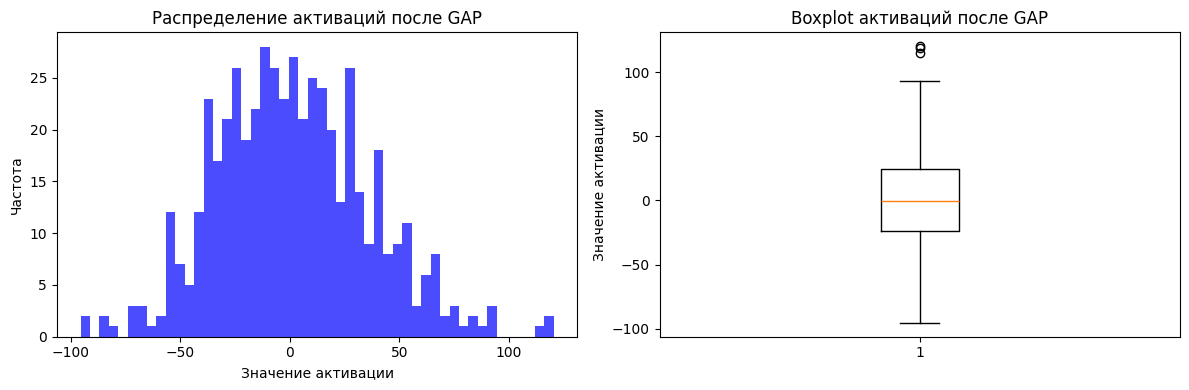

Статистика активаций после GAP:
Среднее: 1.4291
Стандартное отклонение: 34.7325
Минимум: -95.5549
Максимум: 120.3916


In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class VarianceControlNet(nn.Module):
    def __init__(self):
        super(VarianceControlNet, self).__init__()

        # 5 слоев для преобразования к (1, 512, 1, 1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)  # 3x32x32 -> 64x16x16
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 64x16x16 -> 128x8x8

        # Третий слой - с увеличенной дисперсией
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # 128x8x8 -> 256x4x4

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) # 256x4x4 -> 512x2x2
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=2, padding=0) # 512x2x2 -> 512x1x1

        self.gap = nn.AdaptiveAvgPool2d(1)# Global Average Pooling

        self._initialize_weights()# Инициализация весов с контролем дисперсии

    def _initialize_weights(self):
        # Слой 1: стандартная инициализация
        nn.init.normal_(self.conv1.weight, mean=0, std=0.1)
        nn.init.constant_(self.conv1.bias, 0)

        # Слой 2: дисперсия = 0.1
        nn.init.normal_(self.conv2.weight, mean=0, std=0.1)
        nn.init.constant_(self.conv2.bias, 0)

        # Слой 3: дисперсия в 2 раза больше = 0.2
        nn.init.normal_(self.conv3.weight, mean=0, std=0.2)
        nn.init.constant_(self.conv3.bias, 0)

        # Слой 4: дисперсия = 0.1 (как у второго)
        nn.init.normal_(self.conv4.weight, mean=0, std=0.1)
        nn.init.constant_(self.conv4.bias, 0)

        # Слой 5: стандартная инициализация
        nn.init.normal_(self.conv5.weight, mean=0, std=0.1)
        nn.init.constant_(self.conv5.bias, 0)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.conv5(x)  # (1, 512, 1, 1)

        # Global Average Pooling
        gap_output = self.gap(x)
        return gap_output, x

# Проверка дисперсии весов
def check_weight_variances(model):
    print("Проверка дисперсии весов")
    variances = []

    for i, layer in enumerate([model.conv1, model.conv2, model.conv3, model.conv4, model.conv5]):
        weight_variance = torch.var(layer.weight).item()
        variances.append(weight_variance)
        print(f"Слой {i+1}: дисперсия = {weight_variance:.6f}")

    print(f"\nОтношение дисперсий:")
    print(f"Слой 3 / Слой 2 = {variances[2]/variances[1]:.2f}")
    print(f"Слой 3 / Слой 4 = {variances[2]/variances[3]:.2f}")

    return variances

# Визуализация активаций
def visualize_activations(model, input_tensor):
    model.eval()
    with torch.no_grad():
        gap_output, final_output = model(input_tensor)

        # Активации после GAP
        gap_activations = gap_output.flatten().numpy()

        # Визуализация гистограммы
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(gap_activations, bins=50, alpha=0.7, color='blue')
        plt.title('Распределение активаций после GAP')
        plt.xlabel('Значение активации')
        plt.ylabel('Частота')

        plt.subplot(1, 2, 2)
        plt.boxplot(gap_activations)
        plt.title('Boxplot активаций после GAP')
        plt.ylabel('Значение активации')

        plt.tight_layout()
        plt.show()

        print(f"Статистика активаций после GAP:")
        print(f"Среднее: {np.mean(gap_activations):.4f}")
        print(f"Стандартное отклонение: {np.std(gap_activations):.4f}")
        print(f"Минимум: {np.min(gap_activations):.4f}")
        print(f"Максимум: {np.max(gap_activations):.4f}")

# Эксперимент

# Создаем модель
model = VarianceControlNet()

# Проверяем дисперсии весов
variances = check_weight_variances(model)

# Создаем тестовый тензор (имитация изображения CIFAR-10)
test_input = torch.randn(1, 3, 32, 32)  # (batch, channels, height, width)
print(f"\nВходной тензор: {test_input.shape}")

# Прямой проход
gap_output, final_output = model(test_input)
print(f"Выход после 5 слоев: {final_output.shape}")
print(f"Выход после GAP: {gap_output.shape}")

# Визуализируем активации
visualize_activations(model, test_input)

Вариант 3. Контроль количества параметров

Цель: Создание компактной сети.

Создайте архитектуру, используя не более 50000 параметров.

Условие: Один слой должен быть 1x1 сверткой, чтобы уменьшить число каналов.

Эксперимент: Подсчитайте количество параметров каждого слоя и убедитесь, что общая сумма не превышает лимита.

In [28]:
import torch
import torch.nn as nn

class CompactNet(nn.Module):
    def __init__(self):
        super(CompactNet, self).__init__()

        # Слой 1: обычная свертка
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3x32x32 -> 16x32x32

        # Слой 2: обычная свертка
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 16x32x32 -> 32x32x32

        # Слой 3: 1x1 свертка для уменьшения каналов
        self.conv1x1 = nn.Conv2d(32, 8, kernel_size=1)  # 32x32x32 -> 8x32x32

        # Слой 4: обычная свертка
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 8x32x32 -> 16x32x32

        # Слой 5: обычная свертка
        self.conv4 = nn.Conv2d(16, 10, kernel_size=3, padding=1) # 16x32x32 -> 10x32x32

        # Pooling слои для уменьшения размерности
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Полносвязный слой для классификации
        self.fc = nn.Linear(10, 10)  # 10 классов для CIFAR-10

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)  # 16x16x16

        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # 32x8x8

        x = torch.relu(self.conv1x1(x))  # 1x1 свертка! 8x8x8
        x = self.pool(x)  # 8x4x4

        x = torch.relu(self.conv3(x))
        x = self.pool(x)  # 16x2x2

        x = torch.relu(self.conv4(x))
        x = self.avgpool(x)  # 10x1x1

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Функция для подсчета параметров
def count_parameters(model):
    print("Подсчет параметров")
    total_params = 0
    layer_params = {}

    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()
            layer_params[name] = params
            total_params += params
            print(f"{name}: {params:,} параметров")

    return total_params, layer_params

# Функция для детального анализа параметров сверточных слоев
def analyze_conv_parameters(model):
    print("\nАнализ сверточных слоев")

    conv_layers = [
        ('conv1', model.conv1),
        ('conv2', model.conv2),
        ('conv1x1', model.conv1x1),  # 1x1 свертка!
        ('conv3', model.conv3),
        ('conv4', model.conv4)
    ]

    for name, layer in conv_layers:
        # Параметры весов
        weight_params = layer.weight.numel()
        bias_params = layer.bias.numel() if layer.bias is not None else 0
        total_layer_params = weight_params + bias_params

        # Формула для сверточных слоев
        in_channels = layer.in_channels
        out_channels = layer.out_channels
        kernel_size = layer.kernel_size[0] if isinstance(layer.kernel_size, tuple) else layer.kernel_size

        calculated_params = out_channels * (in_channels * kernel_size * kernel_size + 1)

        print(f"\n{name}:")
        print(f"  Входные каналы: {in_channels}")
        print(f"  Выходные каналы: {out_channels}")
        """
        print(f"  Размер ядра: {kernel_size}x{kernel_size}")
        print(f"  Параметры весов: {weight_params:,}")
        print(f"  Параметры смещения: {bias_params:,}")
        print(f"  Всего параметров: {total_layer_params:,}")
        print(f"  Расчет по формуле: {calculated_params:,}")"""

# Основной эксперимент

# Компактная модель
compact_model = CompactNet()

# Подсчет параметров
total_params, layer_params = count_parameters(compact_model)

# анализ
analyze_conv_parameters(compact_model)
"""
# Проверяем полносвязный слой отдельно
print(f"\nПолносвязный слой (fc):")
print(f"  Веса: {compact_model.fc.weight.numel():,}")
print(f"  Смещения: {compact_model.fc.bias.numel():,}")
print(f"  Всего: {compact_model.fc.weight.numel() + compact_model.fc.bias.numel():,}")
"""
print(f"Общее количество параметров: {total_params:,}")


# Тестируем прямой проход
test_input = torch.randn(2, 3, 32, 32)  # 2 изображения CIFAR-10
output = compact_model(test_input)
print(f"\nТест прямого прохода:")
print(f"Вход: {test_input.shape}")
print(f"Выход: {output.shape}")

Подсчет параметров
conv1.weight: 432 параметров
conv1.bias: 16 параметров
conv2.weight: 4,608 параметров
conv2.bias: 32 параметров
conv1x1.weight: 256 параметров
conv1x1.bias: 8 параметров
conv3.weight: 1,152 параметров
conv3.bias: 16 параметров
conv4.weight: 1,440 параметров
conv4.bias: 10 параметров
fc.weight: 100 параметров
fc.bias: 10 параметров

Анализ сверточных слоев

conv1:
  Входные каналы: 3
  Выходные каналы: 16

conv2:
  Входные каналы: 16
  Выходные каналы: 32

conv1x1:
  Входные каналы: 32
  Выходные каналы: 8

conv3:
  Входные каналы: 8
  Выходные каналы: 16

conv4:
  Входные каналы: 16
  Выходные каналы: 10
Общее количество параметров: 8,080

Тест прямого прохода:
Вход: torch.Size([2, 3, 32, 32])
Выход: torch.Size([2, 10])
